In [24]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from catboost import CatBoostClassifier


import warnings

# 경고 무시
warnings.filterwarnings("ignore", category=FutureWarning)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 예시로 'NanumGothic'을 사용

In [26]:
# train = pd.read_csv("../data/test.csv")
test = pd.read_csv("../data/test.csv")

In [27]:
test = test.drop(['ID'], axis=1)


In [28]:
test

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,16800000,36 months,8 years,MORTGAGE,132000000,19.64,12,주택 개선,0,394692,146604.0,0.0,0.0
1,8400000,36 months,5 years,RENT,89971200,15.84,25,부채 통합,0,0,0.0,0.0,0.0
2,17280000,36 months,6 years,RENT,150000000,8.41,20,신용 카드,0,1786980,281820.0,0.0,0.0
3,14400000,36 months,5 years,MORTGAGE,66000000,13.72,30,신용 카드,1,669024,281724.0,0.0,0.0
4,27600000,36 months,5 years,RENT,55200000,30.50,12,신용 카드,0,1250052,614844.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64192,30000000,36 months,3 years,MORTGAGE,78000000,22.08,27,부채 통합,2,1307532,763380.0,0.0,0.0
64193,30000000,60 months,10+ years,MORTGAGE,109200000,12.06,26,부채 통합,0,960612,1245252.0,0.0,0.0
64194,6120000,36 months,10+ years,RENT,39600000,28.80,33,부채 통합,0,131520,80880.0,0.0,0.0
64195,11520000,36 months,10+ years,MORTGAGE,66000000,25.44,41,부채 통합,1,1339536,601872.0,0.0,0.0


In [29]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64197 entries, 0 to 64196
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   대출금액          64197 non-null  int64  
 1   대출기간          64197 non-null  object 
 2   근로기간          64197 non-null  object 
 3   주택소유상태        64197 non-null  object 
 4   연간소득          64197 non-null  int64  
 5   부채_대비_소득_비율   64197 non-null  float64
 6   총계좌수          64197 non-null  int64  
 7   대출목적          64197 non-null  object 
 8   최근_2년간_연체_횟수  64197 non-null  int64  
 9   총상환원금         64197 non-null  int64  
 10  총상환이자         64197 non-null  float64
 11  총연체금액         64197 non-null  float64
 12  연체계좌수         64197 non-null  float64
dtypes: float64(4), int64(5), object(4)
memory usage: 6.4+ MB


In [30]:
label_encoder = LabelEncoder()

test['대출기간'] = label_encoder.fit_transform(test['대출기간'])


In [31]:
# test[test['근로기간'] == '10+years']['근로기간'] = '10+ years'
test.loc[test['근로기간'] == '10+years','근로기간'] = '10+ years'
test.loc[test['근로기간'] == '<1 year','근로기간'] = '< 1 year'
test.loc[test['근로기간'] == '1 years','근로기간'] = '1 year'
test.loc[test['근로기간'] == '3','근로기간'] = '3 years'
test.loc[test['근로기간'] == 'Unknown','근로기간'] = 0
test.loc[test['근로기간'] == '1 year','근로기간'] = 1
test.loc[test['근로기간'] == '2 years','근로기간'] = 1
test.loc[test['근로기간'] == '3 years','근로기간'] = 2
test.loc[test['근로기간'] == '4 years','근로기간'] = 2
test.loc[test['근로기간'] == '5 years','근로기간'] =2
test.loc[test['근로기간'] == '6 years','근로기간'] = 3
test.loc[test['근로기간'] == '7 years','근로기간'] = 3
test.loc[test['근로기간'] == '8 years','근로기간'] =3
test.loc[test['근로기간'] == '9 years','근로기간'] = 3
test.loc[test['근로기간'] == '10+ years','근로기간'] = 4
test.loc[test['근로기간'] == '< 1 year','근로기간'] = 1



test['대출기간'] = test['대출기간'].astype('category')
test['주택소유상태'] =  test['주택소유상태'].astype('category')
test['대출목적'] =  test['대출목적'].astype('category')
test['근로기간']= test['근로기간'].astype(float)

In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64197 entries, 0 to 64196
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   대출금액          64197 non-null  int64   
 1   대출기간          64197 non-null  category
 2   근로기간          64197 non-null  float64 
 3   주택소유상태        64197 non-null  category
 4   연간소득          64197 non-null  int64   
 5   부채_대비_소득_비율   64197 non-null  float64 
 6   총계좌수          64197 non-null  int64   
 7   대출목적          64197 non-null  category
 8   최근_2년간_연체_횟수  64197 non-null  int64   
 9   총상환원금         64197 non-null  int64   
 10  총상환이자         64197 non-null  float64 
 11  총연체금액         64197 non-null  float64 
 12  연체계좌수         64197 non-null  float64 
dtypes: category(3), float64(5), int64(5)
memory usage: 5.1 MB


ValueError: Could not interpret value `대출등급` for `x`. An entry with this name does not appear in `data`.

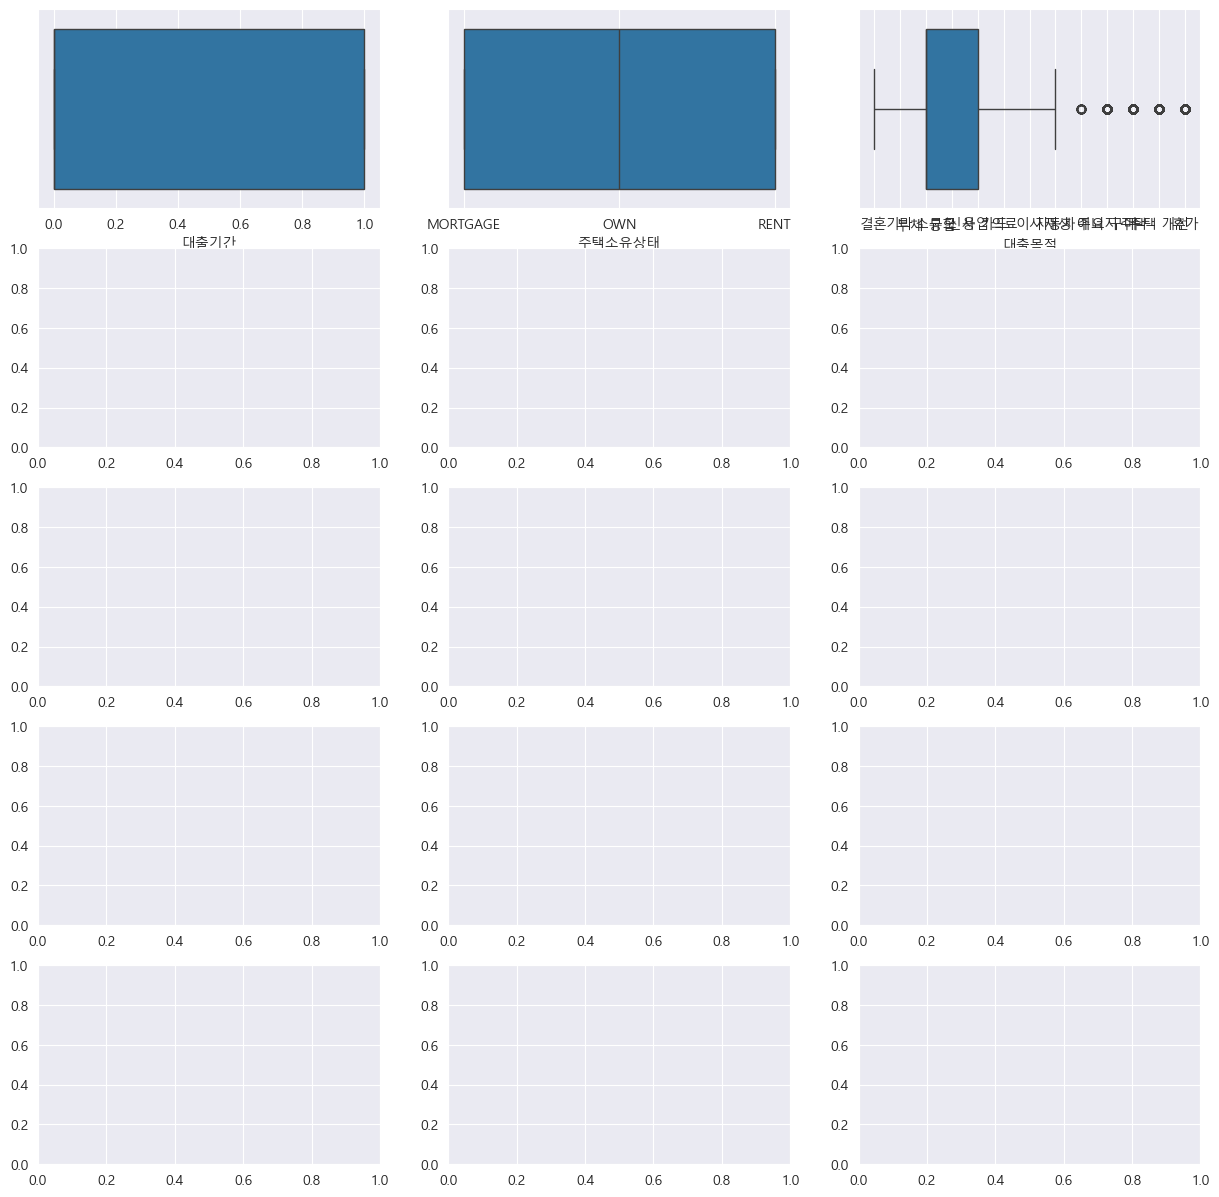

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# 수치형 열 리스트
numeric_cols = ['대출기간', '주택소유상태','대출목적','대출등급','대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수',
                '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액',
                '연체계좌수']

# 4x3 박스플롯 그리기
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
a = 0

# 각각의 subplot에 박스플롯 그리기
for i in range(4):
    for j in range(3):
        if a < len(numeric_cols):
            sns.boxplot(x=numeric_cols[a], data=test, ax=axes[i, j])
            a += 1
        else:
            axes[i, j].set_visible(False)  # 비어있는 서브플롯 숨기기

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [ ]:
# 4x3 히스토그램 그리기
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
a = 0
numeric_cols = ['대출기간', '주택소유상태','대출목적','대출등급','대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수',
                '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액',
                '연체계좌수']

# 각각의 subplot에 히스토그램 그리기
for i in range(4):
    for j in range(3):
        if a < len(numeric_cols):
            axes[i, j].hist(test[numeric_cols[a]], bins=30)
            axes[i, j].set_title(numeric_cols[a])
            a += 1
        else:
            axes[i, j].set_visible(False)  # 비어있는 서브플롯 숨기기

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [20]:
import numpy as np

# 로그 변환 적용
test['연간소득'] = np.log1p(test['연간소득'])
test['부채_대비_소득_비율'] = np.log1p(test['부채_대비_소득_비율'])
test['총상환원금'] = np.log1p(test['총상환원금'])
test['총상환이자'] = np.log1p(test['총상환이자'])
test['총연체금액'] = np.log1p(test['총연체금액'])
test['총계좌수'] = np.log1p(test['총계좌수'])
test['총연체금액'] = np.log1p(test['총연체금액'])
test['최근_2년간_연체_횟수'] = np.log1p(test['최근_2년간_연체_횟수'])


KeyError: '대출등급'

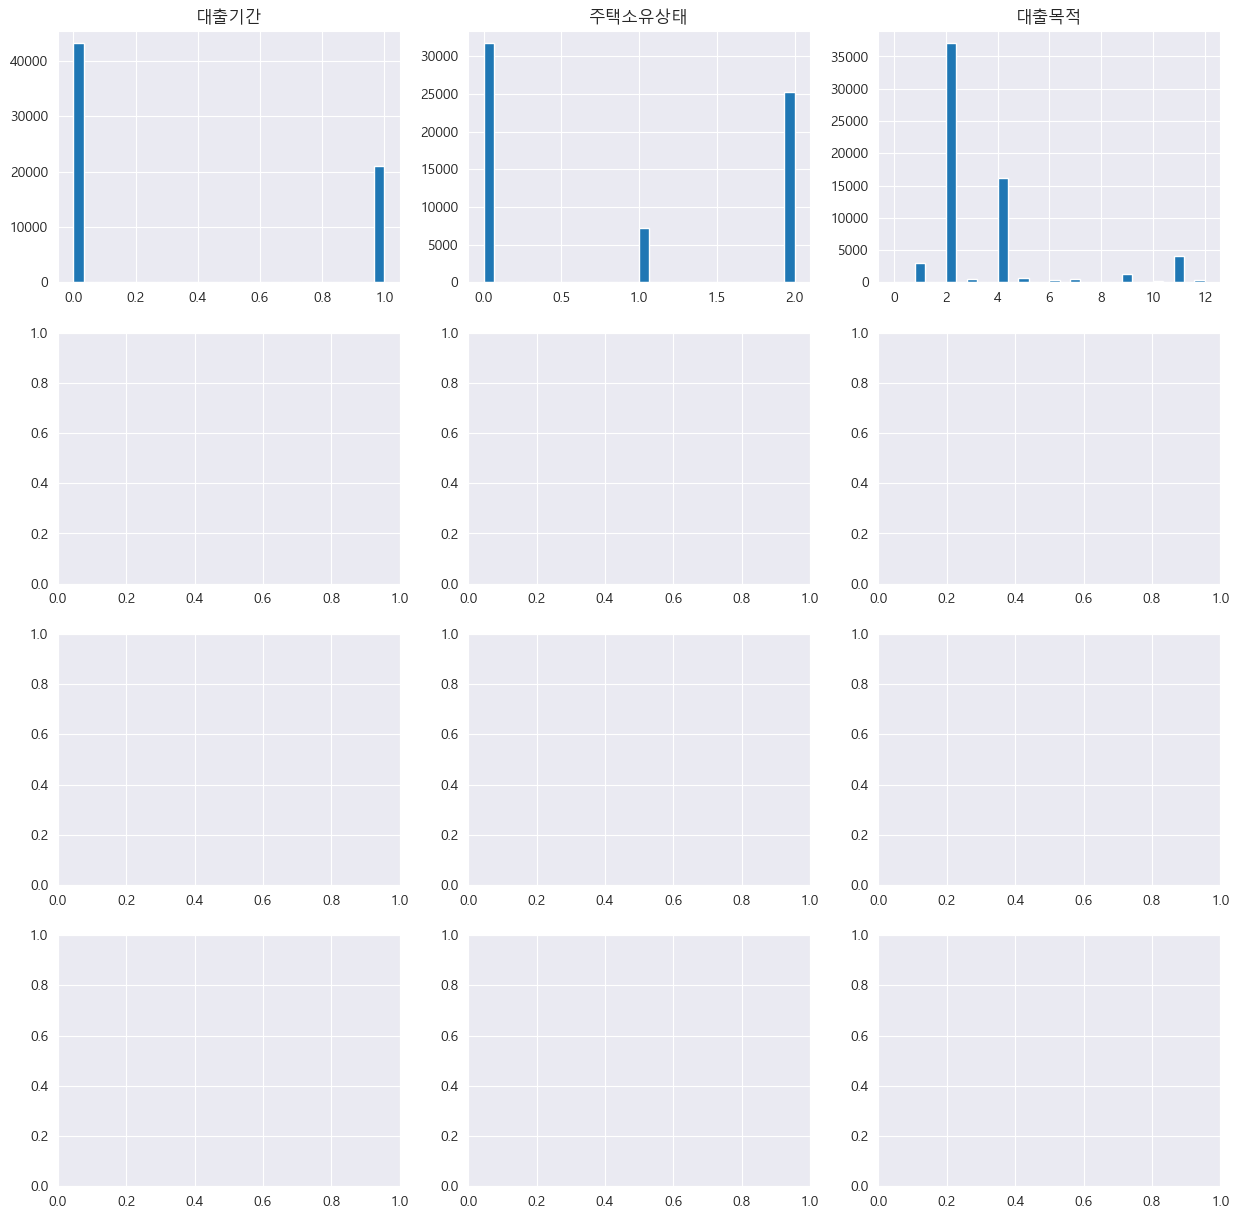

In [26]:
# 4x3 히스토그램 그리기
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
a = 0
numeric_cols = ['대출기간', '주택소유상태','대출목적','대출등급','대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수',
                '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액',
                '연체계좌수']

# 각각의 subplot에 히스토그램 그리기
for i in range(4):
    for j in range(3):
        if a < len(numeric_cols):
            axes[i, j].hist(test[numeric_cols[a]], bins=30)
            axes[i, j].set_title(numeric_cols[a])
            a += 1
        else:
            axes[i, j].set_visible(False)  # 비어있는 서브플롯 숨기기

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [34]:
test

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,16800000,0,3.0,MORTGAGE,132000000,19.64,12,주택 개선,0,394692,146604.0,0.0,0.0
1,8400000,0,2.0,RENT,89971200,15.84,25,부채 통합,0,0,0.0,0.0,0.0
2,17280000,0,3.0,RENT,150000000,8.41,20,신용 카드,0,1786980,281820.0,0.0,0.0
3,14400000,0,2.0,MORTGAGE,66000000,13.72,30,신용 카드,1,669024,281724.0,0.0,0.0
4,27600000,0,2.0,RENT,55200000,30.50,12,신용 카드,0,1250052,614844.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64192,30000000,0,2.0,MORTGAGE,78000000,22.08,27,부채 통합,2,1307532,763380.0,0.0,0.0
64193,30000000,1,4.0,MORTGAGE,109200000,12.06,26,부채 통합,0,960612,1245252.0,0.0,0.0
64194,6120000,0,4.0,RENT,39600000,28.80,33,부채 통합,0,131520,80880.0,0.0,0.0
64195,11520000,0,4.0,MORTGAGE,66000000,25.44,41,부채 통합,1,1339536,601872.0,0.0,0.0


In [35]:
test.to_csv('../data/test_preprocessing.csv', index=False)